<a href="https://colab.research.google.com/github/YifanSong348/STATS303/blob/main/HW/STATS303_Week_3_Spectral_clustering_vs_K_means_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 3 - Homework - Yifan Song (ys251)
###Problem 3. Programming: Spectral clustering vs K-means

In [ ]:
import numpy as np
import pandas as pd
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.datasets.samples_generator import make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
sns.set()
from scipy import sparse
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score
import networkx as nx

##In $R^2$, for each of the three concentric clusters with radius `1, 2.8` and `5`, generate `150` points. Add a noise $∼ N (0, 0.25^2)$ to each of the `450` points to form your dataset.

In [ ]:
# Set random state. 
rs = np.random.seed(25)

def generate_circle_sample_data(r, n, sigma):
    """Generate circle data with random Gaussian noise."""
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    return x, y

def generate_concentric_circles_data(param_list):
    """Generates many circle data with random Gaussian noise."""
    coordinates = [ 
        generate_circle_sample_data(param[0], param[1], param[2])
     for param in param_list
    ]
    return coordinates

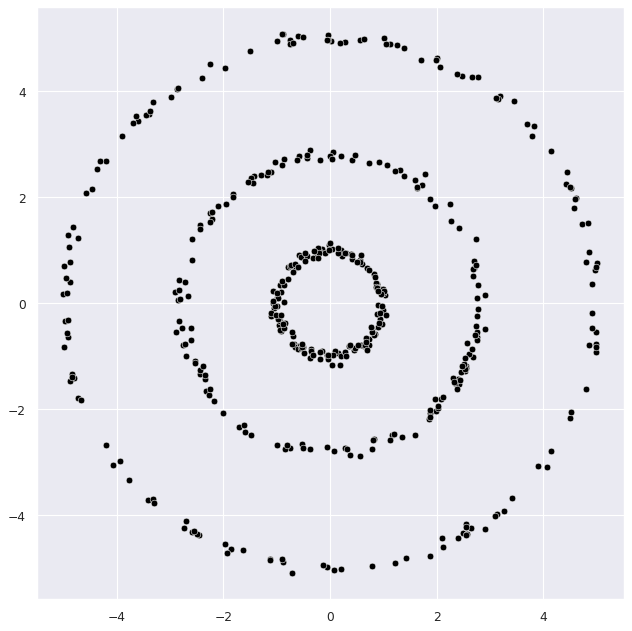

In [ ]:
# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80

# Number of points per circle. 
n = 150
# Radius. 
r_list =[1, 2.8, 5]
# Standar deviation (Gaussian noise). 
sigmas = [0.25**2]

param_lists = [[(r, n, sigma) for r in r_list] for sigma in sigmas] 
# We store the data on this list.
coordinates_list = []

# fig, axes = plt.subplots(1, 1, figsize=(9, 9))

for i, param_list in enumerate(param_lists):

    coordinates = generate_concentric_circles_data(param_list)

    coordinates_list.append(coordinates)
    
    # ax = axes[i]
    
    for j in range(0, len(coordinates)):
    
        x, y = coordinates[j]
        sns.scatterplot(x=x, y=y, color='black')
        # ax.set(title=f'$\sigma$ = {param_list[0][2]}')

plt.tight_layout()

##**1.** Using K-means with *K* = 3, cluster the data points. Show your results in 2D and in three colors.

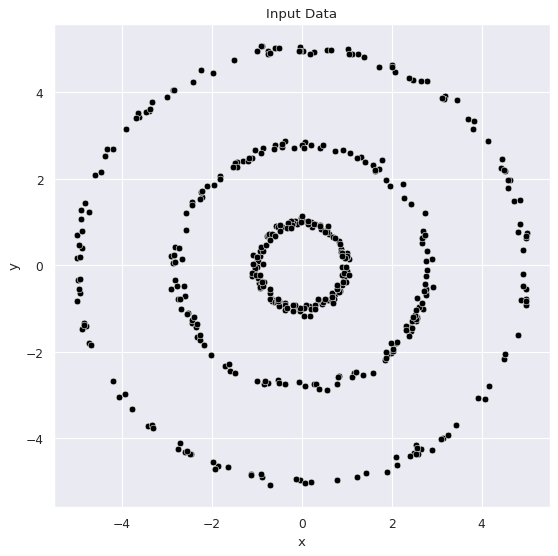

In [ ]:
from itertools import chain

coordinates = coordinates_list[0]

def data_frame_from_coordinates(coordinates): 
    """From coordinates to data frame."""
    xs = chain(*[c[0] for c in coordinates])
    ys = chain(*[c[1] for c in coordinates])

    return pd.DataFrame(data={'x': xs, 'y': ys})

data_df = data_frame_from_coordinates(coordinates)

# Plot the input data.
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', color='black', data=data_df, ax=ax)
ax.set(title='Input Data');

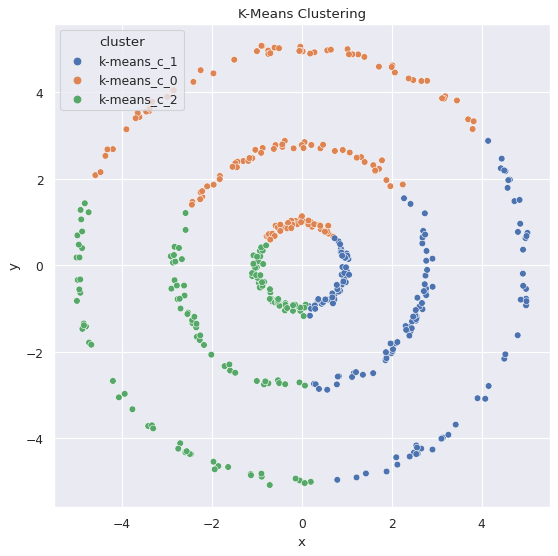

In [ ]:
from sklearn.cluster import KMeans

# inertias = []

# k_candidates = range(1, 10)

# for k in k_candidates:
#     k_means = KMeans(random_state=42, n_clusters=k)
#     k_means.fit(data_df)
#     inertias.append(k_means.inertia_)

# fig, ax = plt.subplots(figsize=(10, 6))
# sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
# sns.scatterplot(x=[k_candidates[2]], y = [inertias[2]], color=sns_c[3], s=150, ax=ax)
# sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
# ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');
k_means = KMeans(random_state=25, n_clusters=3)
k_means.fit(data_df)
cluster = k_means.predict(data_df)

cluster = ['k-means_c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df.assign(cluster = cluster), hue='cluster', ax=ax)
ax.set(title='K-Means Clustering');

##**2.** Construct a similarity graph with k-NN where k = 10. Plot the graph Laplacian *L* (“plt.imshow” your matrix).

Construction of K-nearest neighbors graph

In [ ]:
n_neighbors = 10
knn_dist_graph = kneighbors_graph(X=data_df,
                      n_neighbors=n_neighbors,
                      mode='distance',
                      metric='euclidean',
                      n_jobs=6)
knn_dist_graph.todense()[0][:,:50]

matrix([[0.000, 0.237, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
         0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
         0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.046, 0.000,
         0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
         0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
         0.000, 0.000, 0.211, 0.000, 0.000]])

In [ ]:
sigma = 1
similarity_graph = sparse.csr_matrix(knn_dist_graph.shape)
nonzeroindices = knn_dist_graph.nonzero()
similarity_graph[nonzeroindices] = np.exp( -np.asarray(knn_dist_graph[nonzeroindices])**2 / 2.0 * sigma**2)
similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)
similarity_graph.todense()[0][:,:50]

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


matrix([[0.000, 0.486, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
         0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
         0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.999, 0.000,
         0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
         0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
         0.000, 0.000, 0.489, 0.000, 0.000]])

graph Laplacian

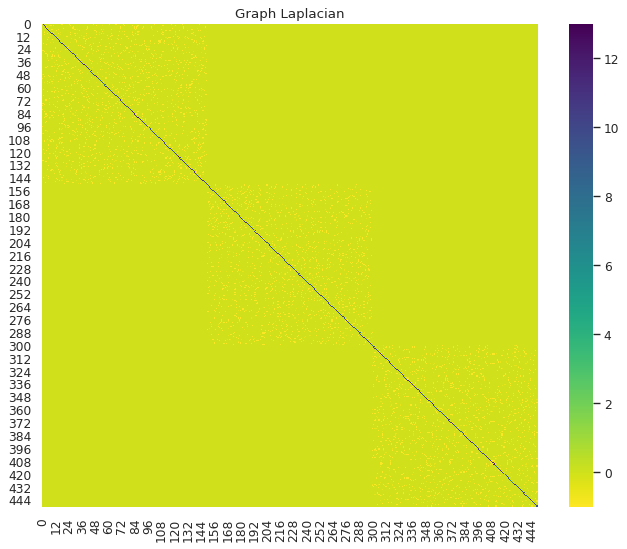

In [ ]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=data_df, nn=10)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

##**3.** Construct the feature matrix *Z* (which is 450 × 2) using the two eigenvectors of *L* corresponding to the second and the third smallest eigenvalues. Then, using K-means with *K* = 3, cluster the features. Show your results in 2D for the original data points.

In [ ]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)

In [ ]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)


In [ ]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=2), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 0.9999999999999998
Max Norm: 1.0000000000000002


In [ ]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

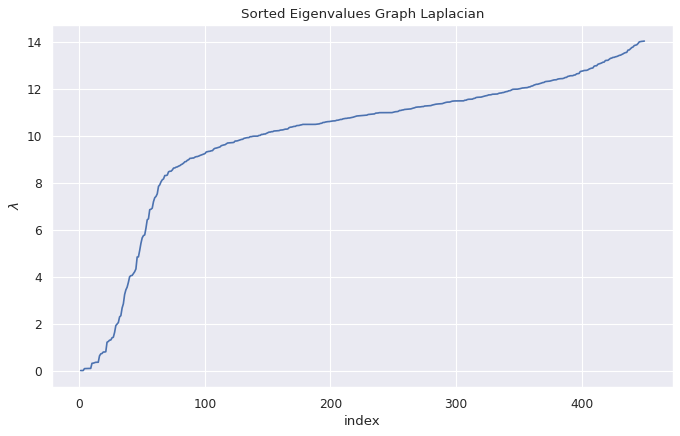

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

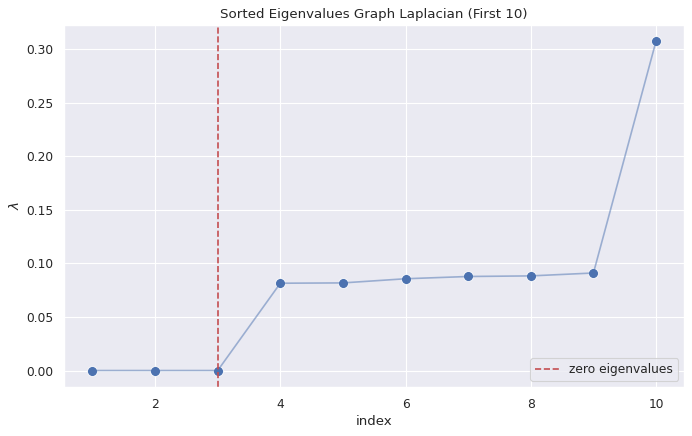

In [ ]:
index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

In [ ]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)
eigenvals[zero_eigenvals_index]

array([[0.000],
       [0.000],
       [0.000]])

In [ ]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

,v_0,v_1,v_2
0,0.08165,0.0,0.0
1,0.08165,0.0,0.0
2,0.08165,0.0,0.0
3,0.08165,0.0,0.0
4,0.08165,0.0,0.0


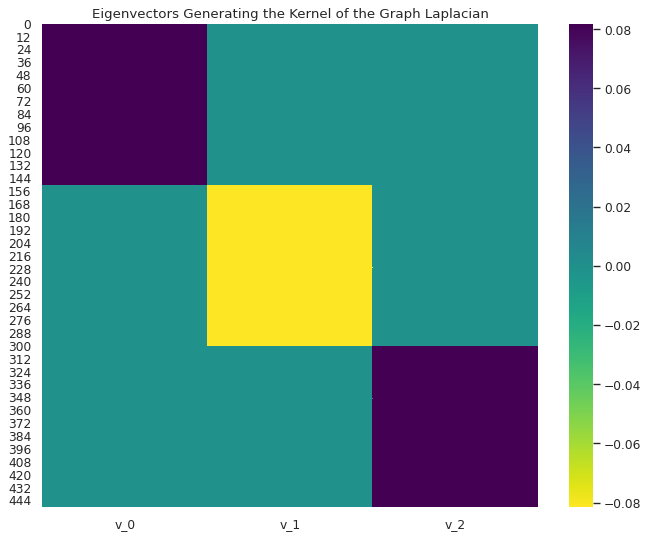

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap='viridis_r')
ax.set(title='Eigenvectors Generating the Kernel of the Graph Laplacian');

In [ ]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

k-means with k = 3

In [ ]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

cluster = run_k_means(proj_df, n_clusters=3)

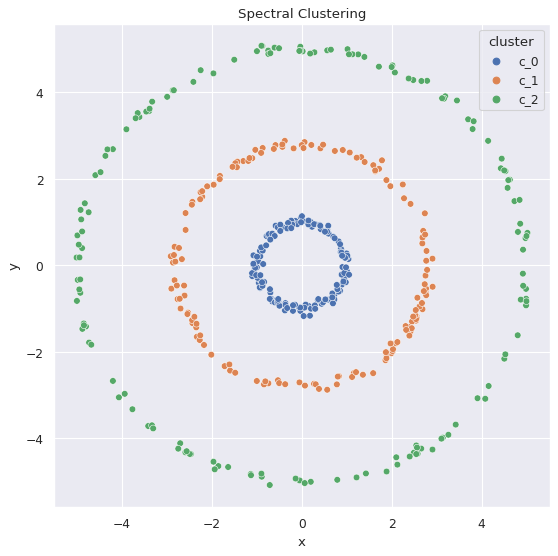

In [ ]:
data_df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');